# Import The Main Libraries

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

# Model

In [145]:
class myRegression:
    def __init__(self):
        self.w = None           # 截距（即w）
        self.b = None           # 系数（即b）
        self.theta = None       # 将截距与系数合并为θ
        self.bgd_params = {}    # 梯度下降的参数
 
    def resetParams(self, theta, **bgd_params):
        """设置系数和参数"""
        theta = np.reshape(theta, (-1,))  # 将系数转为向量格式
        self.theta = theta
        self.w = self.theta[0]
        self.b = self.theta[1:]
        self.bgd_params = bgd_params
        return self
 
    def fit(self, train_x, train_y, method=2):
        """快速进入不同的训练方法"""
        if method in [1, 'normal_equation']:
            self.fitNormalEquation(train_x, train_y)
        elif method in [2, 'gradient_descent']:
            self.fitGradientDescent(train_x, train_y)
        elif method in [3, 'normal_equation_reg']:
            self.fitNormalEquation(train_x, train_y, regularized=True)
        elif method in [4, 'gradient_descent_reg']:
            self.fitGradientDescent(train_x, train_y, regularized=True)
 
    def fitNormalEquation(self, train_x, train_y,
               regularized=False, lamda=1):
        """使用正规方程法训练模型（可选择是否正则化）"""
        # 若不选择正则项，则将其系数设为0
        lamda = 0 if not regularized else lamda
        # 在原有x上加一行1，用于与截距相乘，形成X
        X = np.hstack([np.ones((len(train_x), 1)), train_x])
 
        reg = lamda*np.eye(X.shape[1])
        reg[0, 0] = 0
        theta = np.linalg.pinv(X.T.dot(X) + reg)
        theta = theta.dot(X.T).dot(train_y)
        self.resetParams(theta)
 
    def fitGradientDescent(self, train_x, train_y,
                alpha=0.1, iters=2000, regularized=False, lamda=1,
                alpha_v_step=500, alpha_v_rate=0.95, loss_show=False,
                theta=None):
        """使用梯度下降法训练模型（可选择是否正则化）"""
        # 初始化
        X = np.hstack([np.ones((len(train_x), 1)), train_x])
        num_data, len_theta = X.shape[0], X.shape[1]
        self.theta = np.ones((len_theta, 1)) if theta is None else theta
        lamda = 0 if not regularized else lamda     # 若不选择正则项，则将其系数设为0
        losses = []  # 记录迭代时的损失值变化
 
        # 梯度下降
        for i in range(iters):
            # 对MSE求导
            res = np.reshape(np.dot(X, self.theta), (-1,))
            error = res - train_y
            update = [np.reshape(error * X[:, j], (-1, 1)) for j in range(len_theta)]
            update = np.hstack(update)
            update = np.reshape(np.mean(update, axis=0), (-1, 1))
            # 更新学习率（每隔一定的迭代次数就按比缩小学习率）
            if i > 0 and i % alpha_v_step == 0:
                alpha = alpha * alpha_v_rate
            # 更新参数（若含正则项，则会在梯度下降前适当缩小原系数）
            self.theta = self.theta * (1-alpha*(lamda/num_data)) - alpha*update
            losses.append(self.loss(train_x, train_y))
 
        # 绘图展示迭代过程中损失值的变化
        self.resetParams(self.theta, alpha=alpha, iters=iters, lamda=lamda)
        if loss_show:
            plt.plot(range(len(losses)), losses)
            plt.title("MSE-Loss of BGD")  # 图形标题
            plt.xlabel("iters")  # x轴名称
            plt.show()
        return losses
 
    def predict(self, pred_x):
        pred_x = np.hstack([np.ones((len(pred_x), 1)), pred_x])
        pred_y = pred_x.dot(self.theta)
        pred_y = np.reshape(pred_y, (-1,))  #保证输出结果是向量
        return pred_y
 
    def loss(self, x, y):
        """MSE损失函数"""
        pred_y = self.predict(x)
        mse = np.sum(np.power((pred_y - y), 2)) / y.shape[0]
        return round(mse, 4)
 
    def score(self, x, y):
        """使用R2_score进行模型评价"""
        mse = self.loss(x, y)
        var = np.var(y)
        return round(1-mse/var, 4)
    
    def score_adj(self, x, y, n, k):
        """使用R2_adj_score进行模型评价"""
        r2=self.score(x,y)
        return 1 - (1 - r2) * (n - 1) / (n - k)

# K-Fold (default:5)

In [146]:
# K折交叉验证函数（默认为10折）
def cross_val_score(model, x, y, n_splits=5, fit_method='gradient_descent', image_show=True):
    """
    :param model: 线性模型
    :param x: 数据特征
    :param y: 数据标签
    :param n_splits: 分为几折进行交叉验证
    :param fit_method: 训练模型的方式
    :param image_show: 是否绘图展示每一折验证集的结果
    :return: K折交叉验证的平均MSE值，平均R2—score值，平均R2_adj-score值
    """
    mse_scores, r2_scores,r2_adj_scores = [], [], []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(x):
        train_x, train_y = x[train_index], y[train_index]
        test_x, test_y = x[test_index], y[test_index]
        # 重新训练
        model.fit(train_x, train_y, method=fit_method)
        # 测试集效果
        pred_y = model.predict(test_x)
        if image_show:
            plt.subplot(2,3,len(mse_scores)+1)
            plt.plot(np.arange(len(test_y)), test_y, label='TRUE')
            plt.plot(np.arange(len(test_y)), pred_y, label='PRED')
            plt.legend()
        # 计算模型MSE和R2
        mse_scores.append(model.loss(test_x, test_y))
        r2_scores.append(model.score(test_x, test_y))
        r2_adj_scores.append(model.score_adj(test_x,test_y,test_x.shape[0], test_x.shape[1]))
    if image_show:
        plt.show()
    print("\nMethod='{}':\n\tMSE:".format(fit_method), mse_scores)
    print("\tR2:", r2_scores)
    print("\tR2_adj:", r2_adj_scores)
    return round(np.mean(mse_scores), 4), round(np.mean(r2_scores), 4), round(np.mean(r2_adj_scores), 4)

# Compare Four condition
（ [normal_equation; gradient_descent] × [irregularized ; regularized] )

In [147]:
def compare_training_method(model, x, y):
    """结论：在California房价数据集下，正规方程法最快且效果好，正则化效果会不稳定"""
    methods, scores = ['normal_equation', 'gradient_descent', 'normal_equation_reg', 'gradient_descent_reg'], []
    for method in methods:
        score = cross_val_score(model, x, y, n_splits=5, fit_method=method, image_show=False)
        scores.append(score)
    print('\n\nAverage Score (MSE_Loss, R2_score): ')
    print(dict(zip(methods, scores)))

# Explore the effect of regular term coefficients

In [148]:

def lambda_test(model, x, y):
    """结论：正则项系数lambda由0变大，训练集损失值随之增大，测试集损失值一般先减小后增大（但有时会只有增大过程），lambda在[1,2]区间表现较好"""
    lamdas = list(range(50))
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, random_state=7)
 
    for i in range(2):
        # plt.subplot(2,1,i+1)
        # if i == 0:
        #     plt.title('MSE-Loss of Normal Equation')
        # else:
        #     plt.title('MSE-Loss of Gradient Descent')
        train_scores, test_scores = [], []
        for lamda in lamdas:
            # 分别查看正则项系数变化对正规方程法和梯度下降法的影响
            if i == 0:
                model.fitNormalEquation(train_x, train_y, regularized=True, lamda=lamda)
            else:
                model.fitGradientDescent(train_x, train_y, regularized=True, lamda=lamda)
            train_scores.append(model.loss(train_x, train_y))
            test_scores.append(model.loss(test_x, test_y))
        plt.plot(range(len(lamdas)), train_scores, label='train')
        plt.plot(range(len(lamdas)), test_scores, label='test')
        plt.legend()
        plt.xlabel('lambda')
        plt.ylabel('MSE-Loss')
        plt.show()
    

# load data

In [149]:
lr = myRegression()

data = pd.read_csv("./dataset/data_set.csv")
target = data["house_value"]
data.drop("house_value", axis=1, inplace=True)
data=data.to_numpy()
target=target.to_numpy()
print(data)
print(target)
scaler = MinMaxScaler()
scaling_data = scaler.fit_transform(data)


[[2.17360000e+00 2.90000000e+01 5.48583569e+00 ... 2.05783630e-01
  1.73133661e+00 7.06000000e+02]
 [6.33730000e+00 7.00000000e+00 6.92708333e+00 ... 1.60714286e-01
  2.64019851e+00 7.68000000e+02]
 [2.87500000e+00 4.40000000e+01 5.39333333e+00 ... 1.91594561e-01
  2.42578711e+00 3.00000000e+02]
 ...
 [4.70000000e+00 4.30000000e+01 4.97486034e+00 ... 1.92026951e-01
  2.68627451e+00 3.58000000e+02]
 [4.91250000e+00 3.00000000e+01 5.02669903e+00 ... 1.98937711e-01
  1.91581869e+00 4.12000000e+02]
 [4.11110000e+00 3.60000000e+01 6.10328638e+00 ... 1.69615385e-01
  2.08667737e+00 4.26000000e+02]]
[0.721 2.796 0.827 ... 2.938 3.357 2.156]


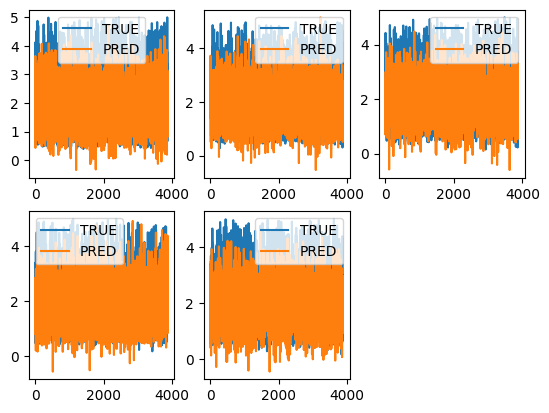


Method='gradient_descent':
	MSE: [0.3973, 0.3949, 0.3607, 0.3589, 0.3765]
	R2: [0.5859, 0.5868, 0.6123, 0.6098, 0.6011]
	R2_adj: [0.5847205334023822, 0.585623096841015, 0.6111957276022786, 0.6086883190883191, 0.5999635327635326]


(0.3777, 0.5992, 0.598)

In [150]:
cross_val_score(lr, scaling_data, target, n_splits=5)

In [151]:
compare_training_method(lr, scaling_data, target)


Method='normal_equation':
	MSE: [0.3474, 0.3446, 0.3209, 0.3211, 0.3272]
	R2: [0.6379, 0.6394, 0.6551, 0.6509, 0.6533]
	R2_adj: [0.636868643190057, 0.6383729155877783, 0.6541176333505956, 0.6499054131054132, 0.6523122507122507]

Method='gradient_descent':
	MSE: [0.3973, 0.3949, 0.3607, 0.3589, 0.3765]
	R2: [0.5859, 0.5868, 0.6123, 0.6098, 0.6011]
	R2_adj: [0.5847205334023822, 0.585623096841015, 0.6111957276022786, 0.6086883190883191, 0.5999635327635326]

Method='normal_equation_reg':
	MSE: [0.348, 0.3482, 0.3207, 0.3203, 0.3289]
	R2: [0.6373, 0.6357, 0.6553, 0.6518, 0.6515]
	R2_adj: [0.6362669342309684, 0.6346623770067323, 0.654318203003625, 0.6508079772079772, 0.6505071225071225]

Method='gradient_descent_reg':
	MSE: [0.3975, 0.3952, 0.361, 0.3591, 0.3768]
	R2: [0.5857, 0.5865, 0.612, 0.6096, 0.6008]
	R2_adj: [0.5845199637493527, 0.5853222423614708, 0.6108948731227344, 0.6084877492877493, 0.5996626780626781]


Average Score (MSE_Loss, R2_score): 
{'normal_equation': (0.3322, 0.6473, 

=====lambda test=====



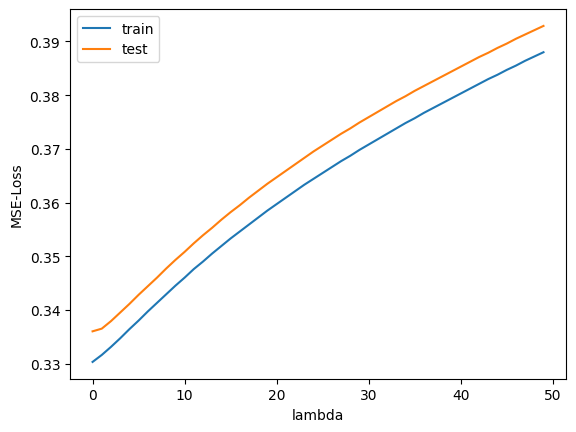

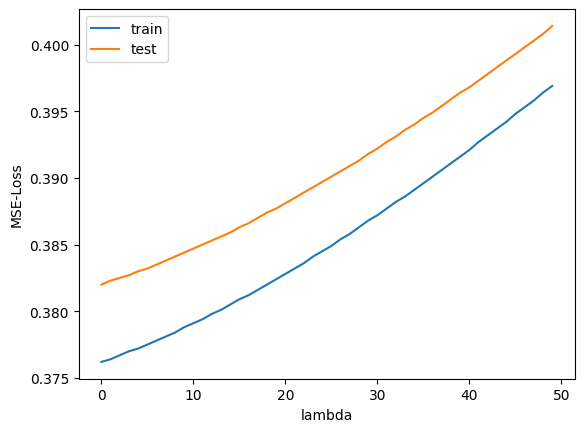

In [152]:
print("=====lambda test=====\n")
lambda_test(lr, scaling_data, target)